# KD-CNN Class

In [ ]:
# import standard libraries
from sklearn.mixture import GaussianMixture
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import layers
from keras import Model
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y
import numpy as np
from scipy.stats import multivariate_normal
import warnings
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

In [ ]:
class kdcnn():

    def __init__(self,
        network,
        num_fc_layers,
        covariance_types = 'full', 
        criterion = None,
        compile_kwargs = {
            "loss": "categorical_crossentropy",
            "optimizer": keras.optimizers.Adam(3e-4)
            },
        fit_kwargs = {
            "epochs": 10,
            "batch_size": 256,
            "verbose": True
            }
        ):
        super().__init__()
        self.polytope_means = {}
        self.polytope_cov = {}
        self.network = network
        self.num_fc_layers = num_fc_layers
        self.encoder = None # convolutional encoder
        self.compile_kwargs = compile_kwargs
        self.fit_kwargs = fit_kwargs
        self.covariance_types = covariance_types
        self.criterion = criterion
        self.num_fc_neurons = 0

    def _get_polytopes(self, X):
        r"""
        Get the polytopes (neural network activation paths) for a given set of observations.
        
        Parameters
        ----------
        X : ndarray
            Input data matrix.

        num_fc_layers: int
            Number of fully-connected layers in the CNN
            
        Returns
        -------
        polytope_memberships : binary list-of-lists
                               Each list represents activations of nodes in the neural network for a given observation
                               0 = not activated; 1 = activated
        """
        polytope_memberships = []
        last_activations = X
        total_layers = len(self.network.layers)
        fully_connected_layers = np.arange(total_layers-self.num_fc_layers, total_layers, 1)

        # Iterate through neural network manually, getting node activations at each step
        for layer_id in fully_connected_layers:
            weights, bias = self.network.layers[layer_id].get_weights()
            
            # Calculate new activations based on input to this layer
            preactivation = np.matmul(last_activations, weights) + bias
            
            # get list of activated nodes in this layer
            if layer_id == total_layers - 1:
                binary_preactivation = (preactivation > 0.5).astype('int')
            else:
                binary_preactivation = (preactivation > 0).astype('int')
            
            # determine the polytope memberships only based on the penultimate layer
            if layer_id == total_layers - 2:
              polytope_memberships.append(binary_preactivation)

            # # determine the polytope memberships only based on all the FC layers
            # polytope_memberships.append(binary_preactivation)
            
            # remove all nodes that were not activated
            last_activations = preactivation * binary_preactivation
          
        #Concatenate all activations for given observation
        polytope_obs = np.concatenate(polytope_memberships, axis = 1)
        polytope_memberships = [np.tensordot(polytope_obs, 2 ** np.arange(0, np.shape(polytope_obs)[1]), axes = 1)]
        self.num_fc_neurons = polytope_obs.shape[1]
        return polytope_memberships

    def fit(self, X, y):
        r"""
        Fits the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        y : ndarray
            Output (i.e. response) data matrix.
        """
        
        self.labels = np.unique(y)
        feature_dim = X.shape[1]

        # get the encoder outputs
        self.encoder = Model(self.network.input, self.network.layers[-(self.num_fc_layers + 1)].output)
        X = self.encoder.predict(X)
        
        for label in self.labels:
            print("label : ", label)
            self.polytope_means[label] = []
            self.polytope_cov[label] = []
            
            # Get all training items that match our given label
            X_ = X[np.where(y==label)[0]]
            
            # Calculate polytope memberships for each observation in X_
            polytope_memberships = self._get_polytopes(X_)[0]
            unique_polytopes = np.unique(polytope_memberships) # get the unique polytopes
            print("Number of Polytopes : ", len(polytope_memberships))
            print("Number of Unique Polytopes : ", len(unique_polytopes))

            polytope_member_count = [] # store the polytope member counts
            for polytope in unique_polytopes:
                idx = np.where(polytope_memberships==polytope)[0] # collect the samples that belong to the current polytope
                polytope_member_count.append(len(idx))
                
                if len(idx) < 10: # don't fit a gaussian to singleton polytopes
                    continue
                
                # get the activation pattern of the current polytope
                current_polytope_activation = np.binary_repr(polytope, width=self.num_fc_neurons)[::-1] 

                # compute the weights
                weights = []
                for member in polytope_memberships:
                    member_activation = np.binary_repr(member, width=self.num_fc_neurons)[::-1] 
                    
                    # # weight based on the total number of matches
                    # weight = np.sum(np.array(list(current_polytope_activation))==np.array(list(member_activation)))/self.num_fc_neurons
                
                    ## weight based on the first mistmatch 
                    match_status = np.array(list(current_polytope_activation))==np.array(list(member_activation))
                    if len(np.where(match_status.astype('int')==0)[0]) == 0:
                        weight = 1.0
                    else:
                        first_mismatch_idx = np.where(match_status.astype('int')==0)[0][0]
                        weight = first_mismatch_idx / self.num_fc_neurons
                    
                    weights.append(weight)

                weights = np.array(weights)

                X_tmp = X_.copy()
                polytope_mean_ = np.average(X_tmp, axis=0, weights=weights) # compute the weighted average of the samples 
                X_tmp -= polytope_mean_ # center the data

                sqrt_weights = np.sqrt(weights)
                sqrt_weights = np.expand_dims(sqrt_weights, axis=-1)
                X_tmp *= sqrt_weights # scale the centered data with the square root of the weights

                # compute the paramters of the Gaussian underlying the polytope
                 
                ## Gaussian Mixture Model
                # gm = GaussianMixture(n_components=1, covariance_type=self.covariance_types, reg_covar=1e-4).fit(X_tmp)
                # polytope_mean_ = gm.means_[0]
                # polytope_cov_ = gm.covariances_[0]
                
                # LedoitWolf Estimator
                covariance_model = LedoitWolf(assume_centered=True)
                covariance_model.fit(X_tmp)
                polytope_cov_ = covariance_model.covariance_ * len(weights) / sum(weights)

                # store the mean and covariances
                self.polytope_means[label].append(
                        polytope_mean_
                )
                self.polytope_cov[label].append(
                        polytope_cov_
                )

            plt.hist(polytope_member_count, bins=30)
            plt.xlabel("Number of Members")
            plt.ylabel("Number of Polytopes")
            plt.show()

    def _compute_pdf(self, X, label, polytope_idx):
        r"""
        Calculate probability density function using the kernel density network for a given group.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        label : string
                A single group we want the PDF for
        polytope_idx : index of a polytope, within label
        """
        polytope_mean = self.polytope_means[label][polytope_idx]
        polytope_cov = self.polytope_cov[label][polytope_idx]

        var = multivariate_normal(
            mean=polytope_mean, 
            cov=polytope_cov, 
            allow_singular=True
            )

        likelihood = var.pdf(X)
        return likelihood

    def predict_proba(self, X):
        r"""
        Calculate posteriors using the kernel density network.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        X = check_array(X)

        likelihoods = np.zeros(
            (np.size(X,0), len(self.labels)),
            dtype=float
        )
        
        for ii,label in enumerate(self.labels):
            for polytope_idx,_ in enumerate(self.polytope_means[label]):
                likelihoods[:,ii] += np.nan_to_num(self._compute_pdf(X, label, polytope_idx))

        proba = (likelihoods.T/(np.sum(likelihoods,axis=1)+1e-100)).T
        return proba

    def predict(self, X):
        r"""
        Perform inference using the kernel density forest.
        Parameters
        ----------
        X : ndarray
            Input data matrix.
        """
        # get the encoder outputs
        X = self.encoder.predict(X)
        return np.argmax(self.predict_proba(X), axis = 1)

#MNIST

In [ ]:
## load data 
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
## normalize
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
## define network 

def getCNN():

  network_base = keras.Sequential()

  # conv blocks
  network_base.add(layers.Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(28, 28, 1)))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=4, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Flatten())

  # fully-connected layers
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(10, activation='softmax'))

  network_base.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(3e-4))
  return network_base

## MNIST Experiments

In [ ]:
network = getCNN()
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 2)         20        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 2)         8         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 4)         76        
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           2

In [ ]:
## train Vanilla-CNN
compile_kwargs = {
            "loss": "categorical_crossentropy",
            "optimizer": keras.optimizers.Adam(3e-4)
            }
fit_kwargs = {
    "epochs": 10,
    "batch_size": 256,
    "verbose": True
    }
network.compile(**compile_kwargs)
network.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
235/235 [==============================] - 37s 34ms/step - loss: 1.6693
Epoch 2/10
235/235 [==============================] - 8s 33ms/step - loss: 0.4843
Epoch 3/10
235/235 [==============================] - 8s 34ms/step - loss: 0.2620
Epoch 4/10
235/235 [==============================] - 8s 34ms/step - loss: 0.1952
Epoch 5/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1616
Epoch 6/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1410
Epoch 7/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1276
Epoch 8/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1176
Epoch 9/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1095
Epoch 10/10
235/235 [==============================] - 8s 33ms/step - loss: 0.1028


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


label :  0
Number of Polytopes :  5923
Number of Unique Polytopes :  38


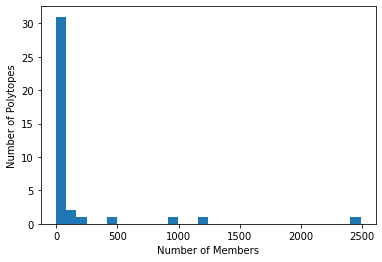

label :  1
Number of Polytopes :  6742
Number of Unique Polytopes :  34


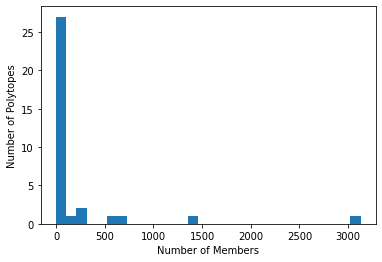

label :  2
Number of Polytopes :  5958
Number of Unique Polytopes :  38


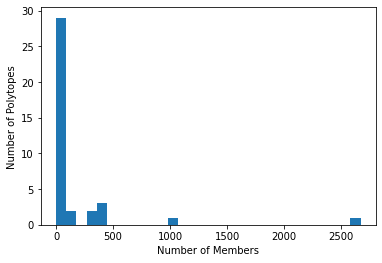

label :  3
Number of Polytopes :  6131
Number of Unique Polytopes :  82


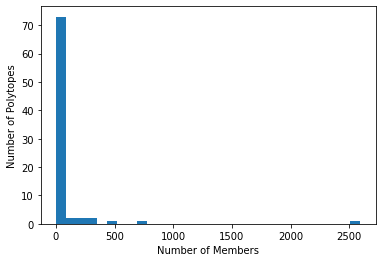

label :  4
Number of Polytopes :  5842
Number of Unique Polytopes :  73


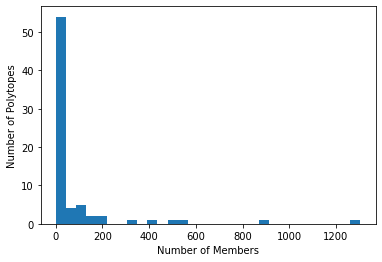

label :  5
Number of Polytopes :  5421
Number of Unique Polytopes :  123


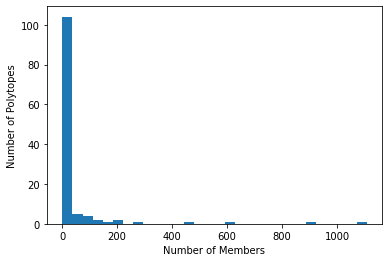

label :  6
Number of Polytopes :  5918
Number of Unique Polytopes :  37


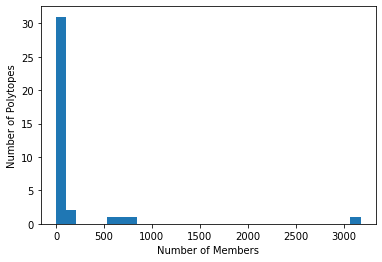

label :  7
Number of Polytopes :  6265
Number of Unique Polytopes :  128


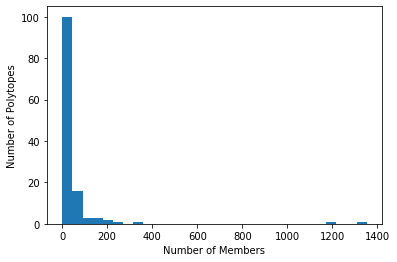

label :  8
Number of Polytopes :  5851
Number of Unique Polytopes :  53


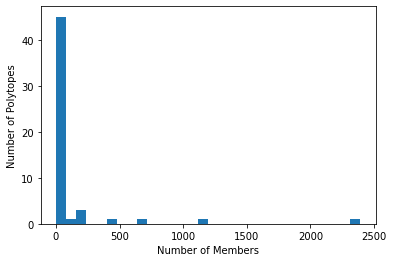

label :  9
Number of Polytopes :  5949
Number of Unique Polytopes :  102


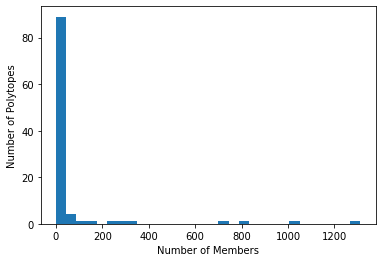

In [ ]:
## train KD-CNN
model_kdn = kdcnn(network=network, num_fc_layers=4)
model_kdn.fit(x_train, y_train)

In [ ]:
## Evaluate KD-CNN
y_pred = model_kdn.predict(x_test)
accuracy = np.mean(y_pred==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/scipy/stats/_multivariate.py:750: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:218: RuntimeWarning: overflow encountered in add


Accuracy : 0.9571


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:220: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
## Evaluate Vanilla CNN
proba_nn = network.predict(x_test)
predicted_label = np.argmax(proba_nn, axis=1)
accuracy = np.mean(predicted_label==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy : 0.9694


# CIFAR-10




In [ ]:
## load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
## normalize
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
## define network 

def getCNN():

  network_base = keras.Sequential()

  # conv blocks
  network_base.add(layers.Conv2D(filters=4, kernel_size=(3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
  network_base.add(layers.BatchNormalization())
  network_base.add(layers.Activation('relu'))

  network_base.add(layers.Flatten())

  # fully-connected layers
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(20, activation='relu'))
  network_base.add(layers.Dense(10, activation='softmax'))

  network_base.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(3e-4))
  return network_base

## CIFAR-10 Experiments

In [ ]:
network = getCNN()
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 4)         112       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 4)         16        
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 8)         296       
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 8)         32        
_________________________________________________________________
activation_11 (Activation)   (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)         

In [ ]:
## train Vanilla-CNN
compile_kwargs = {
            "loss": "categorical_crossentropy",
            "optimizer": keras.optimizers.Adam(3e-4)
            }
fit_kwargs = {
    "epochs": 10,
    "batch_size": 256,
    "verbose": True
    }
network.compile(**compile_kwargs)
network.fit(x_train, keras.utils.to_categorical(y_train), **fit_kwargs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
196/196 [==============================] - 9s 44ms/step - loss: 2.1152
Epoch 2/10
196/196 [==============================] - 9s 44ms/step - loss: 1.8548
Epoch 3/10
196/196 [==============================] - 9s 45ms/step - loss: 1.6764
Epoch 4/10
196/196 [==============================] - 9s 44ms/step - loss: 1.5587
Epoch 5/10
196/196 [==============================] - 9s 44ms/step - loss: 1.4784
Epoch 6/10
196/196 [==============================] - 9s 44ms/step - loss: 1.4166
Epoch 7/10
196/196 [==============================] - 9s 44ms/step - loss: 1.3660
Epoch 8/10
196/196 [==============================] - 9s 44ms/step - loss: 1.3216
Epoch 9/10
196/196 [==============================] - 9s 45ms/step - loss: 1.2849
Epoch 10/10
196/196 [==============================] - 9s 44ms/step - loss: 1.2538


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


label :  0
Number of Polytopes :  5000
Number of Unique Polytopes :  3640


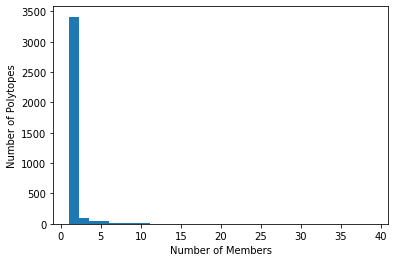

label :  1
Number of Polytopes :  5000
Number of Unique Polytopes :  4187


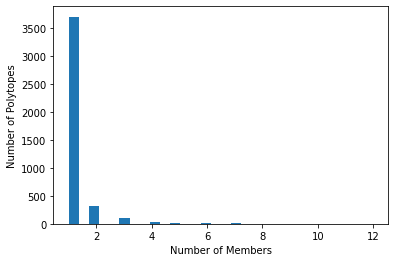

label :  2
Number of Polytopes :  5000
Number of Unique Polytopes :  3427


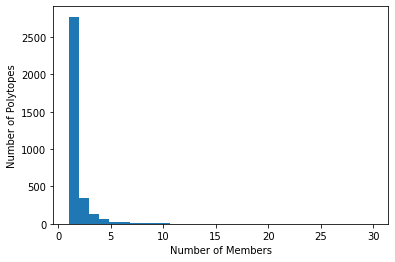

label :  3
Number of Polytopes :  5000
Number of Unique Polytopes :  2886


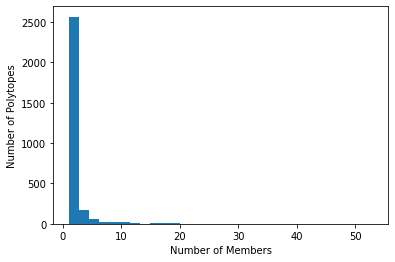

label :  4
Number of Polytopes :  5000
Number of Unique Polytopes :  3506


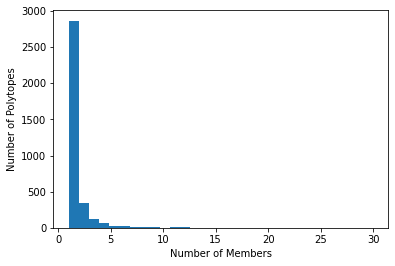

label :  5
Number of Polytopes :  5000
Number of Unique Polytopes :  2773


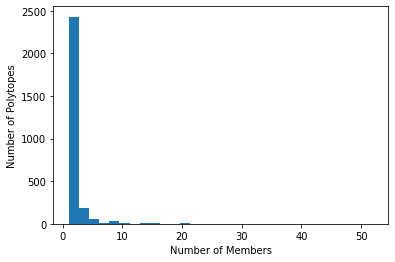

label :  6
Number of Polytopes :  5000
Number of Unique Polytopes :  3434


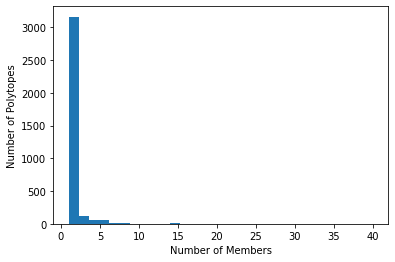

label :  7
Number of Polytopes :  5000
Number of Unique Polytopes :  3227


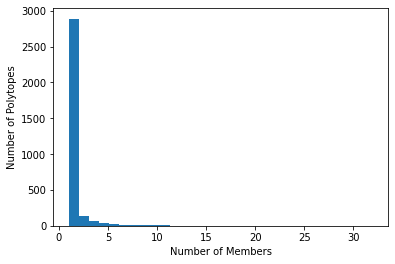

label :  8
Number of Polytopes :  5000
Number of Unique Polytopes :  3234


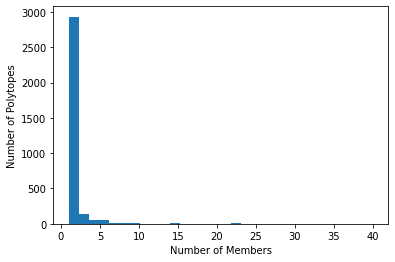

label :  9
Number of Polytopes :  5000
Number of Unique Polytopes :  3652


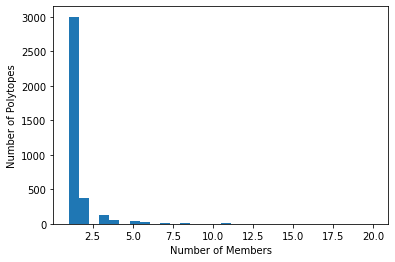

In [ ]:
model_kdn = kdcnn(network=network, num_fc_layers=4)
model_kdn.fit(x_train, y_train)

In [ ]:
## Evaluate KD-CNN
y_pred = model_kdn.predict(x_test)
accuracy = np.mean(y_pred==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy : 0.5217


In [ ]:
## Evaluate Vanilla CNN
proba_nn = model_kdn.network.predict(x_test)
predicted_label = np.argmax(proba_nn, axis=1)
accuracy = np.mean(predicted_label==y_test.squeeze())
print("Accuracy : {}".format(accuracy))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy : 0.5311
